In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8" # 0.9 causes too much lag. 
os.environ['MUJOCO_GL'] = 'egl'
import jax.numpy as jp
import numpy as np
import jax
print("JAX Device:", jax.devices())
from jax import config # Analytical gradients work much better with double precision.
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', 'high')
from mujoco_playground import registry
from mujoco_playground import wrapper
env = registry.load("AnymalTrot")
eval_env = registry.load("AnymalTrot")

JAX Device: [CudaDevice(id=0)]


In [3]:
print(env.lowers)
print()
print(env.uppers)

[-0.72    -9.42478 -9.42478 -0.49    -9.42478 -9.42478 -0.72    -9.42478
 -9.42478 -0.49    -9.42478 -9.42478]

[0.49    9.42478 9.42478 0.72    9.42478 9.42478 0.49    9.42478 9.42478
 0.72    9.42478 9.42478]


In [4]:
step_fn = jax.jit(env.step)
reset_fn = jax.jit(env.reset)

# state = reset_fn(jax.random.PRNGKey(42))
# state = step_fn(state, jp.zeros(env.action_size))

In [5]:
def generate_test_actions(action_dim, steps=20, seed=0):
    rng = np.random.default_rng(seed)
    actions = []

    # 1. 零动作
    actions.append(np.zeros(action_dim))

    # 2. 小幅随机动作
    for _ in range(5):
        actions.append(0.1 * rng.standard_normal(action_dim))

    # 3. 周期性动作（正弦波）
    for t in range(5):
        a = 0.3 * np.sin(2 * np.pi * t / 5) * np.ones(action_dim)
        actions.append(a)

    # 4. 极端动作（边界值）
    actions.append(np.ones(action_dim))    # max
    actions.append(-np.ones(action_dim))   # min

    # 5. 混合：随机 + 正弦
    for t in range(steps - len(actions)):
        a = 0.2 * np.sin(2 * np.pi * t / 10) * np.ones(action_dim)
        a += 0.1 * rng.standard_normal(action_dim)
        actions.append(a)

    return np.array(actions)

# 用法
actions = generate_test_actions(env.action_size, steps=20, seed=42)
print(actions.shape)  # (20, action_dim)
print(actions)      # 打印生成的动作序列


(20, 12)
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.03047171 -0.10399841  0.07504512  0.09405647 -0.19510352 -0.13021795
   0.01278404 -0.03162426 -0.00168012 -0.08530439  0.0879398   0.07777919]
 [ 0.00660307  0.11272412  0.04675093 -0.08592925  0.03687508 -0.09588826
   0.08784503 -0.00499259 -0.01848624 -0.06809295  0.12225413 -0.01545295]
 [-0.04283278 -0.03521336  0.05323092  0.03654441  0.04127326  0.0430821
   0.21416476 -0.0406415  -0.05122427 -0.08137727  0.06159794  0.11289723]
 [-0.01139475 -0.08401565 -0.08244812  0.06505928  0.07432542  0.05431543
  -0.06655097  0.02321613  0.01166858  0.02186886  0.08714288  0.02235955]
 [ 0.06789136  0.00675791  0.02891194  0.06312882 -0.14571558 -0.03196712
  -0.04703727 -0.06388778 -0.02751423  0.14949413 -0.08658311  0.09682784]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0

In [6]:
import time

def rollout(reset_fn, step_fn, actions, seed=0):
    """
    Rollout the TrotAnymal environment using a sequence of actions.
    Args:
        env: TrotAnymal instance
        actions: jp.array of shape [episode_length, action_dim]
        seed: random seed for reset
    Returns:
        states: list of mjx_env.State objects
    """
    rng = jax.random.PRNGKey(seed)
    state = reset_fn(rng)
    states = [state]
    print("start")
    for action in actions:
        start = time.time()
        state = step_fn(state, action)
        states.append(state)
        print("step cost:", time.time() - start)
    return states

states = rollout(reset_fn, step_fn, jp.array(actions), seed=42)

start
step cost: 24.549193143844604
step cost: 26.489941120147705
step cost: 0.018072128295898438
step cost: 0.01941370964050293
step cost: 0.01785898208618164
step cost: 0.017786741256713867
step cost: 0.017011404037475586
step cost: 0.016834259033203125
step cost: 0.017234325408935547
step cost: 0.01807236671447754
step cost: 0.0171353816986084
step cost: 0.016837358474731445
step cost: 0.01673436164855957
step cost: 0.01843428611755371
step cost: 0.0171048641204834
step cost: 0.01600337028503418
step cost: 0.016246557235717773
step cost: 0.016765356063842773
step cost: 0.017679691314697266
step cost: 0.016788482666015625


In [7]:
qpos_list = [state.data.qpos for state in states]
qvel_list = [state.data.qvel for state in states]
reward_list = [state.reward for state in states]
done_list = [state.done for state in states]

# 将列表转换为 NumPy 数组
qpos_array = np.stack(qpos_list)
qvel_array = np.stack(qvel_list)
reward_array = np.stack(reward_list)
done_array = np.stack(done_list)

print("qpos_array shape:", qpos_array.shape)
print("qvel_array shape:", qvel_array.shape)
print("reward_array shape:", reward_array.shape)
print("done_array shape:", done_array.shape)

# np.savez_compressed(
#     'test_trajectory_data.npz',
#     qpos=qpos_array,
#     qvel=qvel_array,
#     reward=reward_array,
#     done=done_array
# )

qpos_array shape: (21, 19)
qvel_array shape: (21, 18)
reward_array shape: (21,)
done_array shape: (21,)


In [8]:
from mujoco_playground.config import locomotion_params
apg_params = locomotion_params.brax_apg_config("AnymalTrot")
print(apg_params)

action_repeat: 1
episode_length: 240
horizon_length: 32
learning_rate: 0.0001
max_gradient_norm: 1000000000.0
network_factory:
  hidden_layer_sizes: !!python/tuple
  - 256
  - 128
normalize_observations: true
num_envs: 64
num_eval_envs: 64
num_evals: 11
policy_updates: 499
use_float64: true



In [9]:
import functools
from brax.training.agents.apg import train as apg
from brax.training.agents.apg import networks as apg_networks

apg_training_params = dict(apg_params)
network_factory = apg_networks.make_apg_networks
if "network_factory" in apg_params:
    del apg_training_params["network_factory"]
    network_factory = functools.partial(
        apg_networks.make_apg_networks, 
        **apg_params.network_factory)

train_fn = functools.partial(
    apg.train, **dict(apg_training_params),
    network_factory=network_factory)

<ErrorbarContainer object of 3 artists>

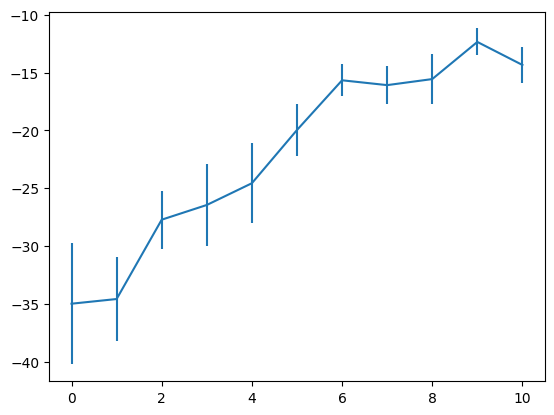

In [11]:
from datetime import datetime
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

def progress(it, metrics):
    times.append(datetime.now())
    x_data.append(it)
    y_data.append(metrics['eval/episode_reward'])
    ydataerr.append(metrics['eval/episode_reward_std'])

make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=eval_env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
    progress_fn=progress
)

import matplotlib.pyplot as plt
plt.errorbar(x_data, y_data, yerr=ydataerr)

In [16]:
import mediapy as media

def render_rollout(reset_fn, step_fn, env, inference_fn, n_step, render_every, seed=0):
    rng = jax.random.PRNGKey(seed)
    state = reset_fn(rng)
    rollout_list = [state]
    for i in range(n_step):
        act_rng, rng = jax.random.split(rng)
        action, _ = inference_fn(state.obs, act_rng)
        state = step_fn(state, action)
        rollout_list.append(state)
    traj = rollout_list[::render_every]
    fps = 1.0 / (env.dt * render_every)
    frames = env.render(traj, height=480, width=640)
    media.show_video(frames, fps=fps, loop=True)

    return frames

demo_env = registry.load("AnymalTrot")
demo_step_fn = jax.jit(demo_env.step)
demo_reset_fn = jax.jit(demo_env.reset)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

frames = render_rollout(
    demo_reset_fn, demo_step_fn, demo_env, 
    jit_inference_fn, n_step=200, render_every=3, seed=1)

100%|██████████| 67/67 [00:00<00:00, 320.88it/s]


In [17]:
from brax.io import model
model_path = '/tmp/trotting_playground_2hz_policy'
model.save_params(model_path, params)